In [ ]:
# Import libraries and define paths
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a relative path to the data directory.
# This script works on any machine assuming the 'data/studentlife/' directory exists at the root of the project.
# The '../' navigates up one level from the 'src' directory to the project root.
RAW_DATA_PATH = '../data/studentlife/'

def build_data_path(modality_name):
  """
  Constructs a full path to a specific data modality folder.
  
  Args:
    modality_name (str): The name of the data folder (e.g., 'activity').
    
  Returns:
    str: The path to the data folder.
  """
  # os.path.join correctly concatenates path components for any OS
  path = os.path.join(RAW_DATA_PATH, modality_name)
  
  # os.path.abspath converts the relative path to an absolute path
  return os.path.abspath(path)

# Add paths for more modalities here:
activity_path = build_data_path('activity')
print(f"Activity path: {activity_path} is ready.")

In [ ]:
# Count Unique Subjects by ID
def count_unique_ids(fpath, modality_name):
  """
  Performs and prints a unique (subject) id count on dataset.
  """
  files_in_folder = os.listdir(fpath)

  print(files_in_folder)

  # create a set for holding the extracted user ids
  unique_subject_ids = set()

  # loop through all matching filenames in the subdirectory
  for file in files_in_folder:
    if file.startswith(f"{modality_name}_u") and file.endswith('.csv'):
      # Extract the user id from the filename
      # Example: 'activity_u00.csv' -> ['activity', 'u00']
      user_id = file.split('.')[0].split('_')[1]

      # Add the user id to the set
      unique_subject_ids.add(user_id)

  # the final count of unique subjects is returned as the size of the set
  return len(unique_subject_ids)

# Count Unique Subject ids
count_unique_ids(activity_path, 'activity')

In [ ]:
# Create a DataFrame
def load_data_frame(modality_path):
  """
  Loads all CSVs from a data path into a DataFrame.
  Converts the timestamps to datetime objects for easier date/time manipulation.
  """
  files_in_folder = os.listdir(modality_path)

  # A list to hold all DataFrames before combining them
  df_list = []

  modality_name = os.path.basename(modality_path)
  print(f"Loading modality: {modality_name}")

  # loop through all matching filenames in the subdirectory
  for file in files_in_folder:
    if file.startswith(f"{modality_name}_u") and file.endswith('.csv'):
      # File path to the specified file
      # Example: if modality_path is ".../activity" and file is "activity_u00.csv",
      # the file_path will be ".../activity/activity_u00.csv"
      file_path = os.path.join(modality_path, file)

      # Read the CSV file to a DataFrame
      df = pd.read_csv(file_path)

      # Add the user ID as a column to the DataFrame
      user_id = file.split('.')[0].split('_')[1]
      df['user_id'] = user_id

      # Convert the timestamp column to a datetime object
      df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

      print(f"Loaded: {user_id}", df.head())

      # Add the DataFrame to the list of DataFrames
      df_list.append(df)

  # Combine the DataFrames into one main DataFrame
  # Take the timestamp column and make it the index of the main DataFrame
  main_df = pd.concat(df_list).set_index('timestamp')
  return main_df

In [ ]:
# Clean a DataFrame
def clean_column_names(df):
  """
  Removes whitespaces from all columns of a DataFrame.
  """
  # Strip whitespace from each column name
  for col in df.columns:
    df.rename(columns={col: col.strip()}, inplace=True)
  return df

In [ ]:
# Load data into a DataFrame
activity_df = load_data_frame(activity_path)

# Clean the column names
activity_df = clean_column_names(activity_df)

In [ ]:
# Summary statistics
activity_df.head(10) # First 10 rows
activity_df.info() # DataFrame info
activity_df.describe() 

# When does my data start and end?
print(f"Data starts on: {activity_df.index.min()}")
print(f"Data ends on: {activity_df.index.max()}")

# What is the amount of data?
print(f"There are {len(activity_df)} rows of data.")

In [ ]:
# How is the data distributed? Who has complete data? Who has messy data? Are there any gaps??
# Create a histogram to show the distribution of data entries over time.

# Require the DataFrame index to be a timestamp (DateTime).
# Group the data into 100 distinct time periods (bins).
# Access the index as a Pandas Series before calling .hist()
pd.Series(activity_df.index).hist(bins=200)

# Plot a histogram of the timestamps to visualize when data was collected.
plt.title('Distribution of Activity Inferences Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Inferences')

# Save the figure to a file before showing it (uncomment below to run)
# plt.savefig('../results/figures/histogram.png')
plt.show()

In [ ]:
# Count the number of unique values in the 'uid' column
num_users = activity_df['uid'].nunique()

print(f"There are {num_users} unique users in the dataset.")

In [ ]:
# Create Data Sparcity Plot (### WARNING: not optimized, not efficient- dont run)
sorted_users = sorted(activity_df['uid'].unique())

# Create a large figure to accommodate all users and the long timeline
plt.figure(figsize=(20, 14))

# Get both the user's name and a number (i) for their position on the y-axis
for i, user in enumerate(sorted_users):

    # Filter the main DataFrame to get data for only the current user
    user_df = activity_df[activity_df['user_id'] == user]

    # Check if the user has any data before trying to plot
    if not user_df.empty:
        # Get the timestamps (the index) for this user
        timestamps = user_df.index

        # Create a list of y-values that is just the user's vertical position (i)
        y_values = [i] * len(timestamps)

        # Plot the timestamps as small dots for this user
        plt.plot(timestamps, y_values, marker='.', markersize=1, linestyle='none')

# Format the plot
plt.yticks(range(len(sorted_users)), sorted_users)

plt.title('Data Sparsity Plot for Activity Modality', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('User ID', fontsize=14)
plt.grid(axis='x', linestyle=':') # Add a light vertical grid to help track dates
plt.tight_layout() # Adjusts plot to ensure everything fits without overlapping

# Save the figure to a file before showing it (uncomment below to run)
# plt.savefig('../results/figures/sparsity_plot.png')
plt.show()

In [ ]:
# Create Data Sparsity Plot (optimized version- more efficient to process millions of rows of data)
# Rather than trying to plot 22.9 million data points just plot one point per day for each user if they have data for that day
sorted_users = sorted(activity_df['uid'].unique())

# Create a large figure to accommodate all users and the long timeline
plt.figure(figsize=(20, 14))

print("Generating optimized sparsity plot...")

# Get both the user's name and a number (i) for their position on the y-axis
for i, user in enumerate(sorted_users):

    # Filter the main DataFrame to get data for only the current user
    user_df = activity_df[activity_df['user_id'] == user]

     # Check if the user has any data before trying to plot
    if not user_df.empty:

        # Plot one point per day that has data and not every single timestamp for optimization.
        # .normalize() sets the time part of the timestamp to midnight.
        # .unique() then gives us a list of each unique day.
        unique_days = user_df.index.normalize().unique()

        # Create a list of y-values that is the user's vertical position (i)
        y_values = [i] * len(unique_days)

        # Plot the unique days as slightly larger dots for visibility
        plt.plot(unique_days, y_values, marker='.', markersize=2, linestyle='none')

# Format the plot
plt.yticks(range(len(sorted_users)), sorted_users)
plt.title('Data Sparsity Plot for Activity Modality (Presence per Day)', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('User ID', fontsize=14)
plt.grid(axis='x', linestyle=':')
plt.tight_layout()

# Save the figure to a file before showing it (uncomment below to run)
# plt.savefig('../results/figures/sparsity_plot.png')
plt.show()

In [ ]:
# Data Transformation (Vectors)
# activity_inference column values: 0, 1, 2, 3 where:
# 0	Stationary
# 1	Walking
# 2	Running
# 3	Unknown

# pd.get_dummies converts this column into new columns for each unique category
activity_vectors = pd.get_dummies(activity_df['activity inference'], prefix='activity')

# Display the first few rows of new vector DataFrame
activity_vectors.head()

In [ ]:
# Concatenate the original DataFrame with the new vector one
activity_vectors_df = pd.concat([activity_df, activity_vectors], axis=1)

# Drop the activity_inference column (dont need it)
activity_vectors_df = activity_vectors_df.drop('activity inference', axis=1)

# Display the first few rows of combined DataFrames
activity_vectors_df.head()

In [ ]:
# Summary Statistics

# Group by user and sum the vectors
# Since each vector value is a number, adding them gives a total count of readings per user for each activity_inference type
user_activity_summary = activity_vectors_df.groupby('user_id').sum()

# Display the summary table
user_activity_summary

In [ ]:
# Compare users by calculating the proportion of time each user spent on each activity

# Get the total number of readings for each user
total_readings_per_user = activity_vectors_df.groupby('user_id').size()

# Divide the summary count table by the total readings for each user
# axis=0 tells pandas to align the division row-by-row using the index (user_id)
user_activity_proportions = user_activity_summary.div(total_readings_per_user, axis=0)

# Multiply by 100 to express it as a percentage
user_activity_proportions = user_activity_proportions * 100

print("Percentage of time spent in each activity per user:")
user_activity_proportions.head(50)

In [ ]:
# Output DataFrames to CSVs
# Define the relative path to the output directory for processed data
PROCESSED_DATA_PATH = '../results/processed_data/'

# Using os.path.join() is the correct way to create paths.
vectors_filepath = os.path.join(PROCESSED_DATA_PATH, 'activity_vectors.csv')
summary_filepath = os.path.join(PROCESSED_DATA_PATH, 'user_activity_summary.csv')
proportions_filepath = os.path.join(PROCESSED_DATA_PATH, 'user_activity_proportions.csv')

# Save the DataFrames to CSV
print("Saving processed DataFrames to CSV files...")

### WARNING: activity_vectors_df is a very large file (almost 23 million rows of data) and may take a lot of time to write:
# activity_vectors_df.to_csv(vectors_filepath) 

# Saving summary and proportions DataFrames
user_activity_summary.to_csv(summary_filepath)
user_activity_proportions.to_csv(proportions_filepath)

print("Successfully saved data to the 'results/processed_data/' directory.")

In [ ]:
# Determing Missingness/Completeness
# Find users with the least complete data in the study

# To determine:
# Calculate total days in the study period
total_study_days = (activity_df.index.max() - activity_df.index.min()).days
print(f"Total study days: {total_study_days}")

# Store a "completness score" for each user
completeness_scores = {}

# Loop through each user to calculate their active days
for user in sorted_users:
    # Filter for user data and create a separate DataFrame for each
    user_df = activity_df["user_id"] == user
    # Find number of active days per user

    ### WARNING: activity_vectors_df is a very large file (almost 23 million rows of data) and may take a lot of time to write:
    active_days = user_df.groupby(user_df.index.date).size()
    # Get a count of the total number of active days
    num_active_days = len(active_days)
    # Calculate the completeness score
    completeness_scores[user] = num_active_days / total_study_days * 100

# Sort scores from highest to lowest
sorted_scores = completeness_scores.sort_values(ascending=True)

print("Completeness Scores:")
print(sorted_scores)


In [ ]:
# Get the earliest and latest timestamps from the df index
start_date = activity_df.index.min()
end_date = activity_df.index.max()

# .normalize() to set the time to midnight, ignoring hours/minutes (study begins and ends at different parts of the day, normalize a 24hr period)
normalized_start = start_date.normalize()
normalized_end = end_date.normalize()

total_study_days = (normalized_end - normalized_start).days + 1
print(f"Total study days: {total_study_days}")

user_active_days = activity_df.groupby('user_id').apply(lambda df: df.index.normalize().nunique(), include_groups=False)

# Calculate the completeness score for all users at once
completeness_scores = (user_active_days / total_study_days) * 100

# Sort the scores to see the lowest compliance first
sorted_scores = completeness_scores.sort_values(ascending=True)

print("\nCompleteness Scores (% of days with data):")
print(sorted_scores)

In [ ]:
# Low completeness users (remove users w/ < 75% completeness)
low_completeness_users = sorted_scores.head(9)
users_to_remove = low_completeness_users.index.tolist()

print("The users with the lowest completeness (to be removed):")
print(users_to_remove)

In [ ]:
print(f"Starting number of users: {activity_df['user_id'].nunique()}")

# Remove the users with low completeness
cleaned_activity_df = activity_df[~activity_df['user_id'].isin(users_to_remove)]

print(f"Number of users after cleaning: {cleaned_activity_df['user_id'].nunique()}")

In [ ]:
# Goal: Find and remove days where a significant number of users have sparse 'activity' data.
# Doing this preserves all 49 user data while hopefully providing a better understanding of data missingness.
# Will also improve data quality of the time series?? Hopefully :)

In [ ]:
# Can possibly remove a day where < 35 users had good data?
# Figure out days to remove:
GOOD_DAY_THRESHOLD = 6000
RELIABLE_DAY_THRESHOLD_USERS = 35

# Count the total number of readings for each user for each day ('D' in pandas).
daily_reading_counts = activity_df.groupby('user_id').resample('D').apply(
    'size'
)

daily_compliant_users = (daily_reading_counts > GOOD_DAY_THRESHOLD).groupby(level='timestamp').sum()
days_to_remove = daily_compliant_users[daily_compliant_users < RELIABLE_DAY_THRESHOLD_USERS].index

print(f"Using a threshold of >{GOOD_DAY_THRESHOLD} daily readings for a good data day.")
print(f"Found {len(days_to_remove)} days to remove where less than {RELIABLE_DAY_THRESHOLD_USERS} users were compliant.")
print("Dates to be removed:")
print(days_to_remove.strftime('%Y-%m-%d').tolist())

original_dates = activity_df.index.normalize()
final_cleaned_df = activity_df[~original_dates.isin(days_to_remove)]

print(f"\nOriginal number of rows of data: {len(activity_df):,}")
print(f"Number of rows after removing unreliable data days: {len(final_cleaned_df):,}")
print(f"Number of data days remaining: {final_cleaned_df.index.normalize().nunique()}")


In [ ]:
# What is considered a 'high quality' day for activity across user subjects???
# activity sensor records a point every 2-3 seconds during an active day

# Using the FULL activity study of all 49 users:
# resample data by day to calculate total number of activity readings across all users per DAY
# Find the max of those totals to determine 'high daily completeness' and the min to determine 'low daily completeness score'
# For example: A typical 'high complete score' day has >=15,000 readings while a 'low complete score' day may have <=1,000 readings.

# Count the total number of readings for each user for each day ('D' in pandas).
daily_reading_counts = activity_df.groupby('user_id').resample('D').apply(
    'size'
)

#  fill any missing days for a user with 0 readings into the matrix
matrix = daily_reading_counts.unstack(level=0).fillna(0)

print("Summary Statistics for Daily Reading Counts")
print(matrix.stack().describe())

# Output:
# count- is total number of days (49 users * 67 days = 3283 days)
# mean- a student has >6,900 activity readings on average
# std- standard deviation (highly variable where some days have lots of readings and some have just a few)
# min- some people have complete missing days
# 25%- low data day (completeness) threshold? 25% of days across all users have <6000 readings
# 50%- mean or middle (completeness) threshold? 50% of days across all users have >8000 readings
# 75%- high data day (completenes) threshold? 75% of days across all users have <8200 readings
# Max- user with the highest number of readings on their most active day

In [ ]:
# Create some visualizations of daily completeness to analyze which days to remove
# Heatmap: what is the distribution and intersection of the data missingness?
# Import the seaborn library for nicer heatmaps
import seaborn as sns

plt.figure(figsize=(20, 16))
sns.heatmap(matrix, cmap=sns.cubehelix_palette(as_cmap=True), cbar_kws={'label': 'data points in an active day'})

plt.title('Daily Data Completeness per User', fontsize=20)
plt.xlabel('user id', fontsize=14)
plt.ylabel('date', fontsize=14)
plt.show()

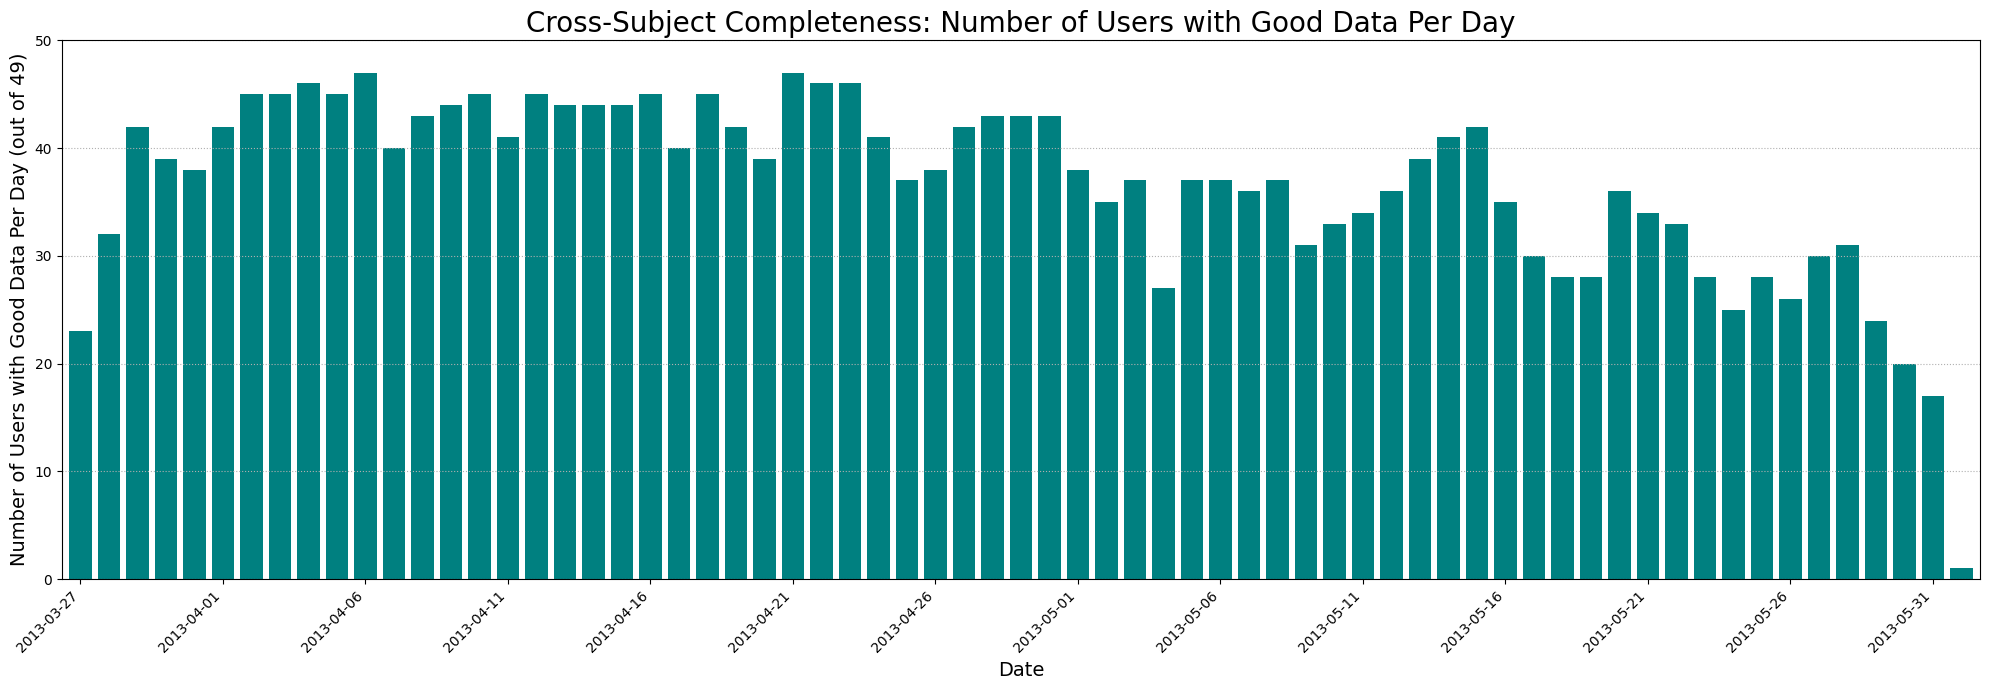

In [38]:
# What is an active day? Using the 25th percentile as a starting point
# 25%- low data day (completeness) threshold? 25% of days across all users have 6000 readings or less
GOOD_DAY_THRESHOLD = 6000

# count how many users met this threshold for each day
# daily_reading_counts > GOOD_DAY_THRESHOLD ?? T or F
daily_data_compliant_users = (daily_reading_counts > GOOD_DAY_THRESHOLD).groupby(level='timestamp').sum()


# Bar chart
plt.figure(figsize=(20, 7))
daily_data_compliant_users.plot(kind='bar', width=0.8, color='teal')

plt.title('Cross-Subject Completeness: Number of Users with Good Data Per Day', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Users with Good Data Per Day (out of 49)', fontsize=14)
plt.ylim(0, 50)

# Make the x-axis labels show every few days for readability
tick_locations = range(0, len(daily_data_compliant_users.index), 5)
tick_labels = [daily_data_compliant_users.index[i].strftime('%Y-%m-%d') for i in tick_locations]
plt.xticks(ticks=tick_locations, labels=tick_labels, rotation=45, ha='right')

plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

In [39]:
# Simple Linear Regression

# Find the overall trend of student activity over the entire term

# y-variable: stationary readings per day for the entire user set
stationary_df = activity_df[activity_df['activity inference'] == 0]

model_series = stationary_df['activity inference'].resample('D').count().dropna()

regression_df = model_series.reset_index()
regression_df.columns = ['date', 'stationary_readings']

# x-variable: timestamps
# convert the date into a simple number (0, 1, 2, ...)
regression_df['days_since_start'] = (regression_df['date'] - regression_df['date'].min()).dt.days

print("Data prep for Simple Linear Regression")
regression_df.head()

Data prep for Simple Linear Regression


,date,stationary_readings,days_since_start
0,2013-03-27,192323,0
1,2013-03-28,258953,1
2,2013-03-29,314772,2
3,2013-03-30,301769,3
4,2013-03-31,292975,4


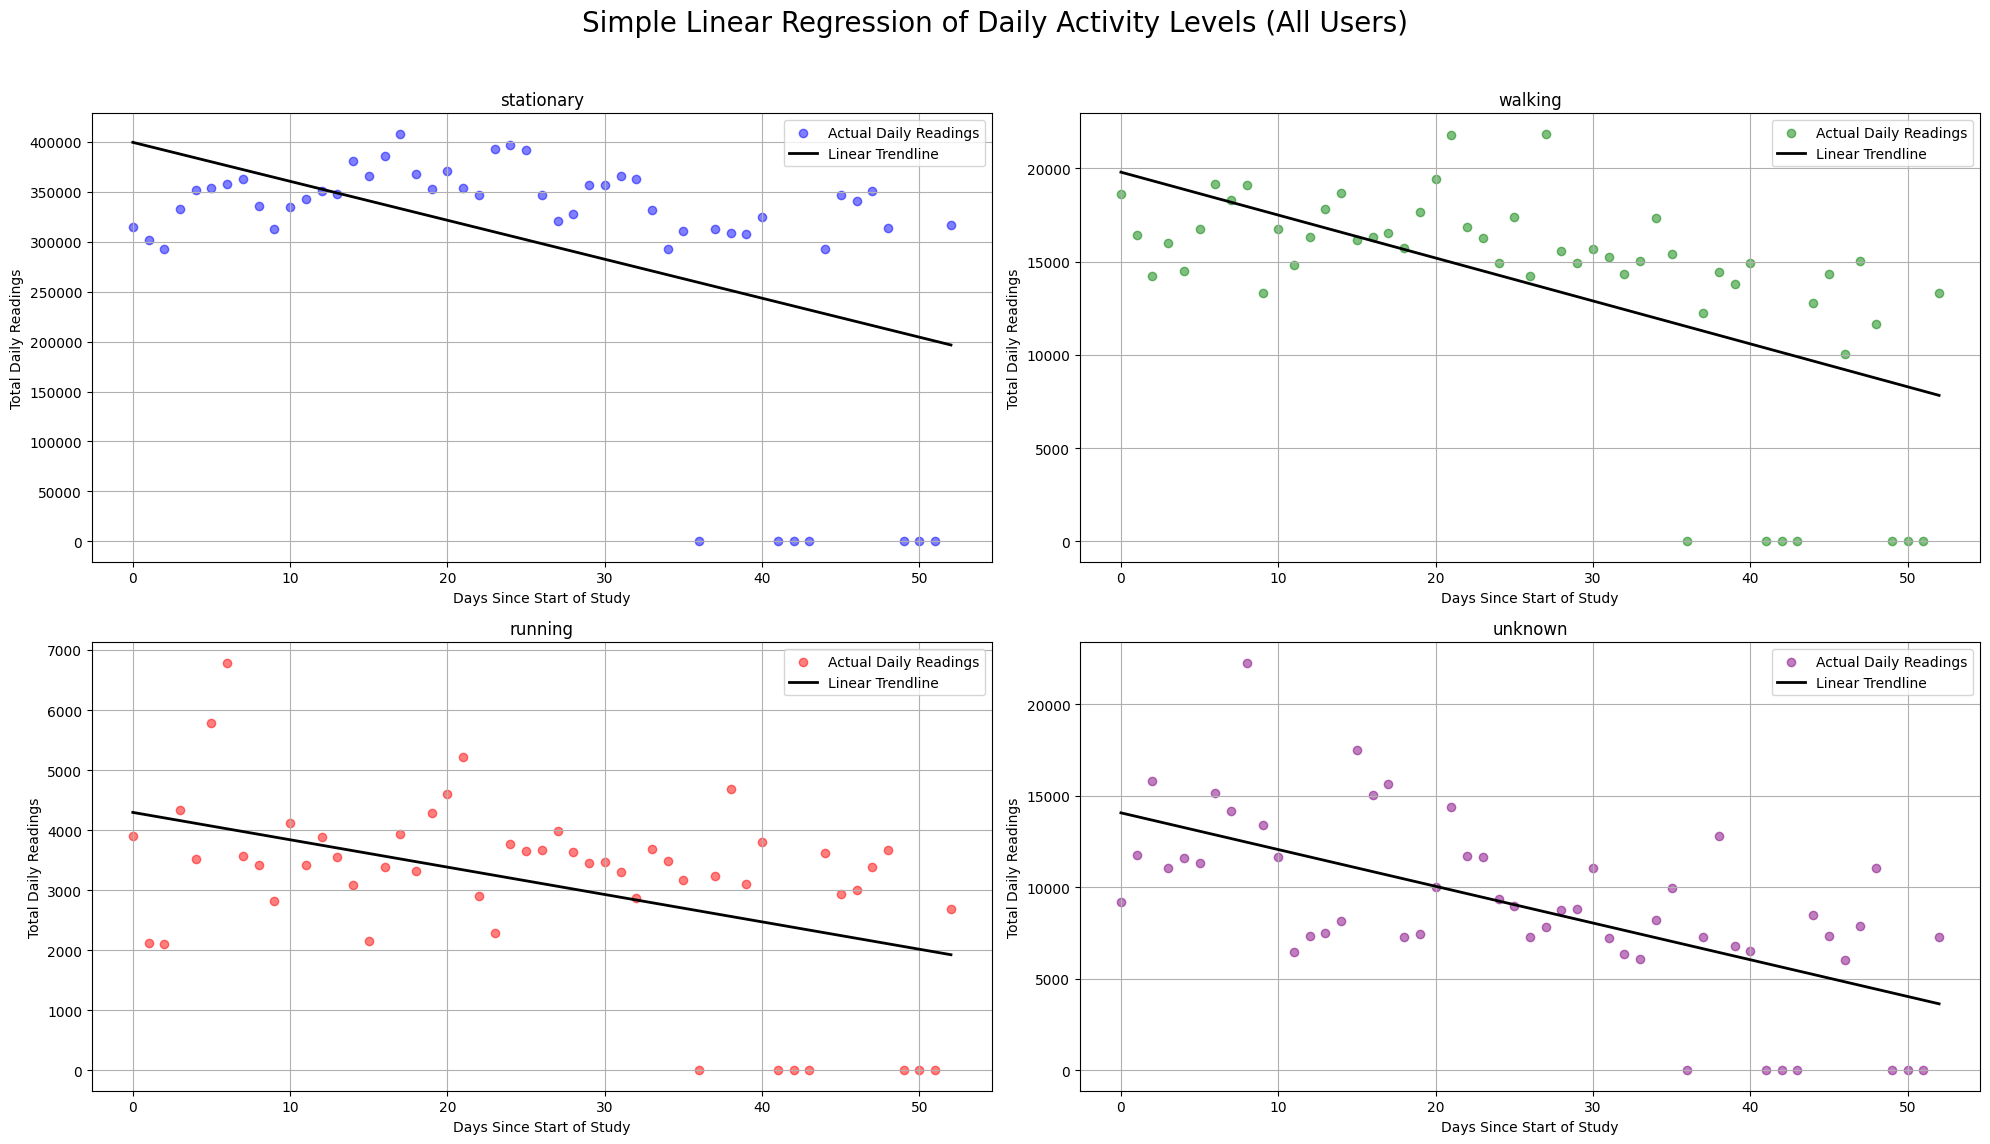

In [40]:
# Linear Regression model

from sklearn.linear_model import LinearRegression

# Data prep

vectors_df = pd.get_dummies(final_cleaned_df['activity inference'], prefix='activity')
activity_df_wide = pd.concat([final_cleaned_df, vectors_df], axis=1)

daily_group_summary = activity_df_wide[['activity_0', 'activity_1', 'activity_2', 'activity_3']].resample('D').sum()

regression_df = daily_group_summary.reset_index()
regression_df['days_since_start'] = (regression_df['timestamp'] - regression_df['timestamp'].min()).dt.days


# 2x2 grid

activity_columns = ['activity_0', 'activity_1', 'activity_2', 'activity_3']
activity_titles = ['stationary', 'walking', 'running', 'unknown']
colors = ['blue', 'green', 'red', 'purple']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Simple Linear Regression of Daily Activity Levels (All Users)', fontsize=20)

for i, activity in enumerate(activity_columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    X = regression_df[['days_since_start']]
    y = regression_df[activity]

    lr_model = LinearRegression()
    lr_model.fit(X, y)

    ax.scatter(X, y, color=colors[i], alpha=0.5, label='Actual Daily Readings')

    ax.plot(X, lr_model.predict(X), color='black', linewidth=2, label='Linear Trendline')

    ax.set_title(activity_titles[i])
    ax.set_ylabel('Total Daily Readings')
    ax.set_xlabel('Days Since Start of Study')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [42]:
# Compare the Linear Progressive Model to the Polynomial Model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

regression_df = daily_group_summary.reset_index()
regression_df['days_since_start'] = (regression_df['timestamp'] - regression_df['timestamp'].min()).dt.days

X = regression_df[['days_since_start']]
y = regression_df['activity_0'] # Focusing on Stationary activity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)


# Define error metrics

# Define the function for sMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calculate metrics for both models
metrics_data = {
    'Metric': ['RMSE', 'sMAPE (%)'],
    'Simple Linear Regression': [np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)), smape(y_test, y_pred_lr)],
    'Polynomial Regression (Deg 2)': [np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly)), smape(y_test, y_pred_poly)]
}

error_df = pd.DataFrame(metrics_data).set_index('Metric')

print("Model performance comparisons:")
error_df

Model performance comparisons:


,Simple Linear Regression,Polynomial Regression (Deg 2)
Metric,,
RMSE,139820.578235,128918.496808
sMAPE (%),63.869873,62.705884


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


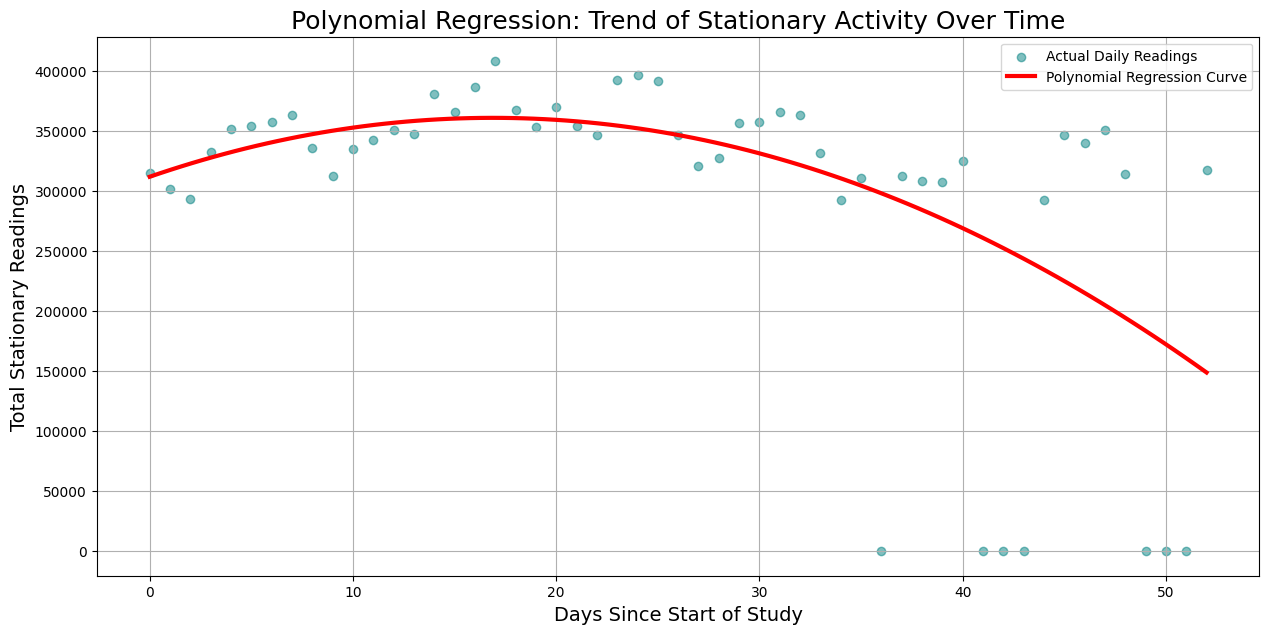

In [43]:
# Polynomial Regression model

X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)

y_poly_curve = poly_model.predict(X_range_poly)

plt.figure(figsize=(15, 7))

plt.scatter(X, y, color='teal', alpha=0.5, label='Actual Daily Readings')

plt.plot(X_range, y_poly_curve, color='red', linewidth=3, label='Polynomial Regression Curve')

plt.title('Polynomial Regression: Trend of Stationary Activity Over Time', fontsize=18)
plt.xlabel('Days Since Start of Study', fontsize=14)
plt.ylabel('Total Stationary Readings', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


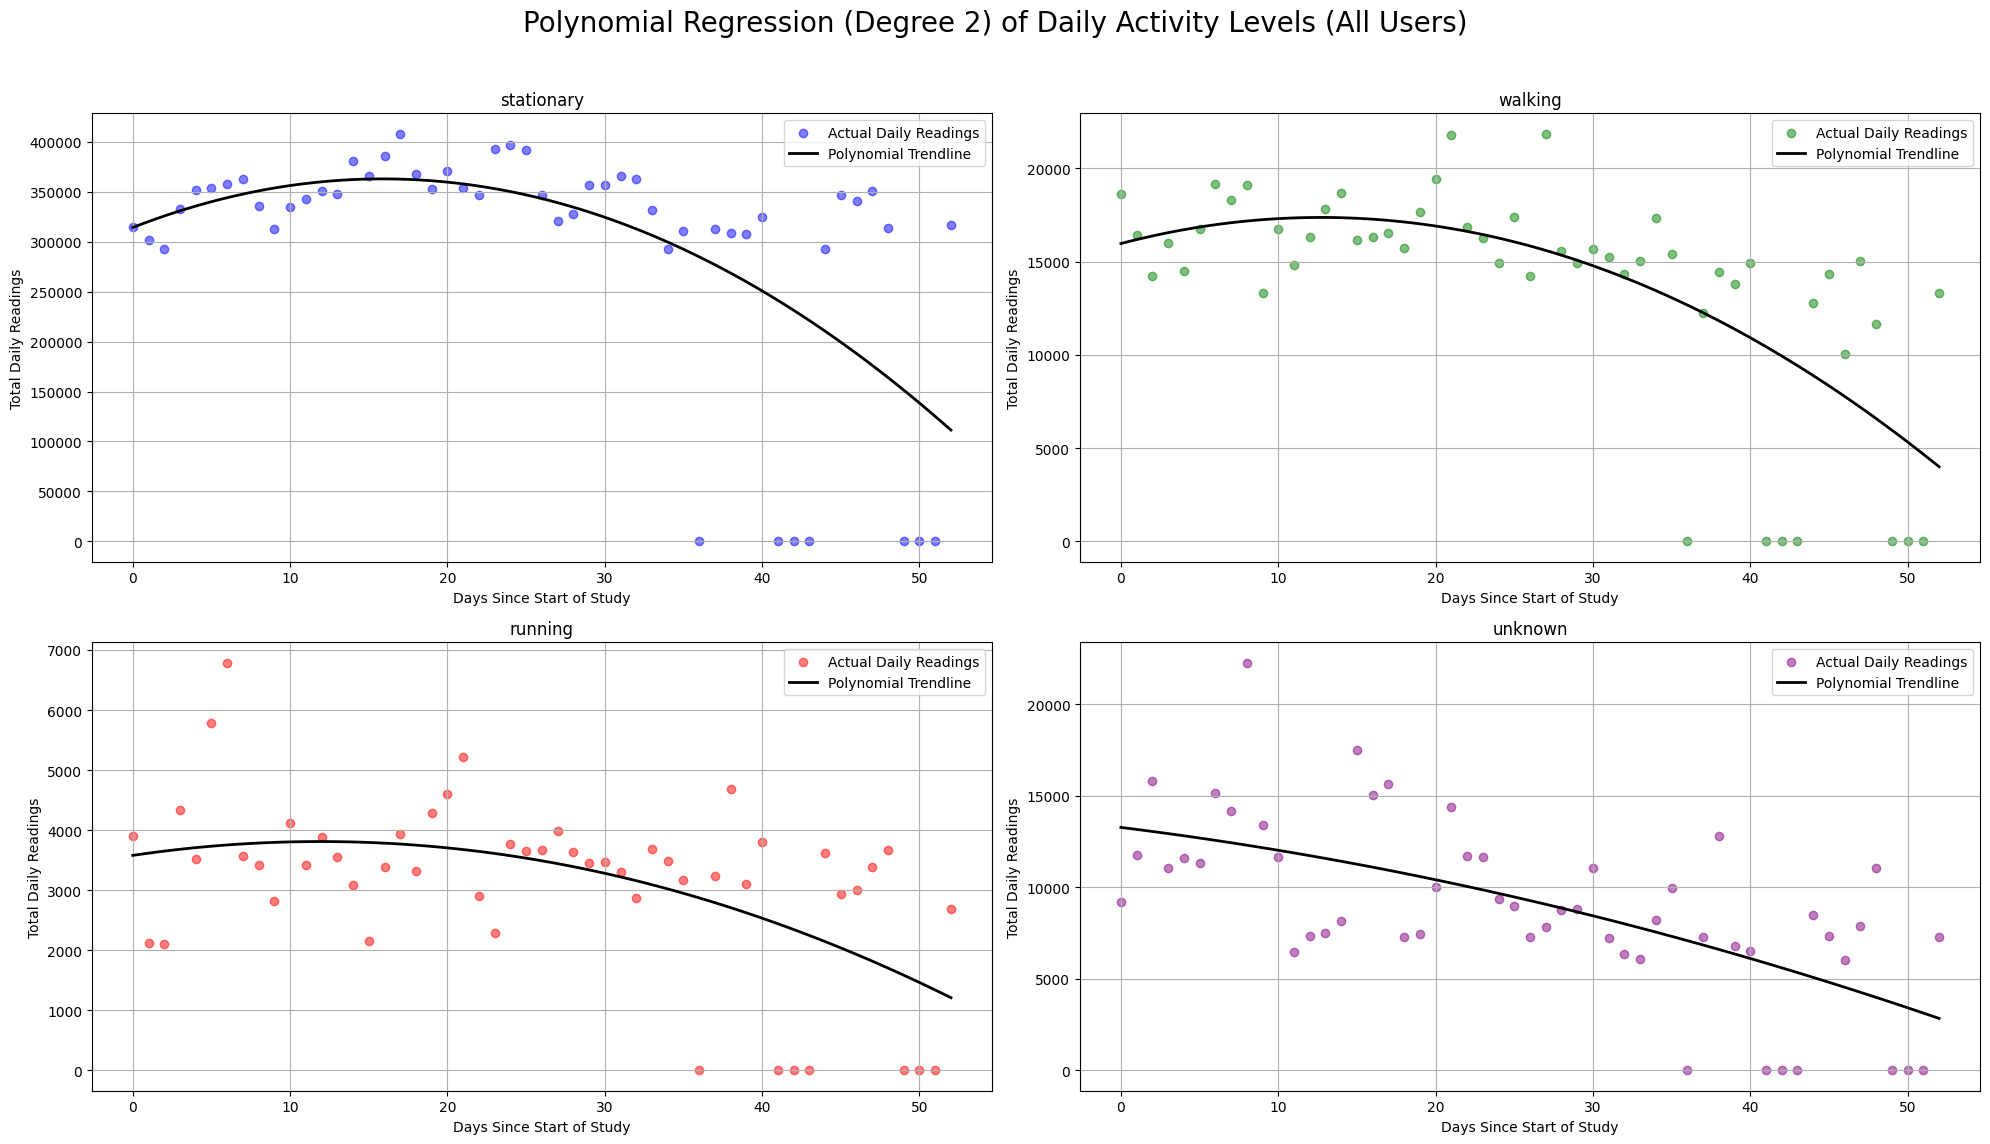

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt


activity_columns = ['activity_0', 'activity_1', 'activity_2', 'activity_3']
activity_titles = ['stationary', 'walking', 'running', 'unknown']
colors = ['blue', 'green', 'red', 'purple']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Polynomial Regression (Degree 2) of Daily Activity Levels (All Users)' , fontsize=20)


for i, activity in enumerate(activity_columns):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    X = regression_df[['days_since_start']]
    y = regression_df[activity]

    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)

    # Fit the model to the transformed features
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)


    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_range_poly = poly.transform(X_range)
    y_poly_curve = poly_model.predict(X_range_poly)

    ax.scatter(X, y, color=colors[i], alpha=0.5, label='Actual Daily Readings')

    ax.plot(X_range, y_poly_curve, color='black', linewidth=2, label='Polynomial Trendline')

    ax.set_title(activity_titles[i])
    ax.set_ylabel('Total Daily Readings')
    ax.set_xlabel('Days Since Start of Study')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


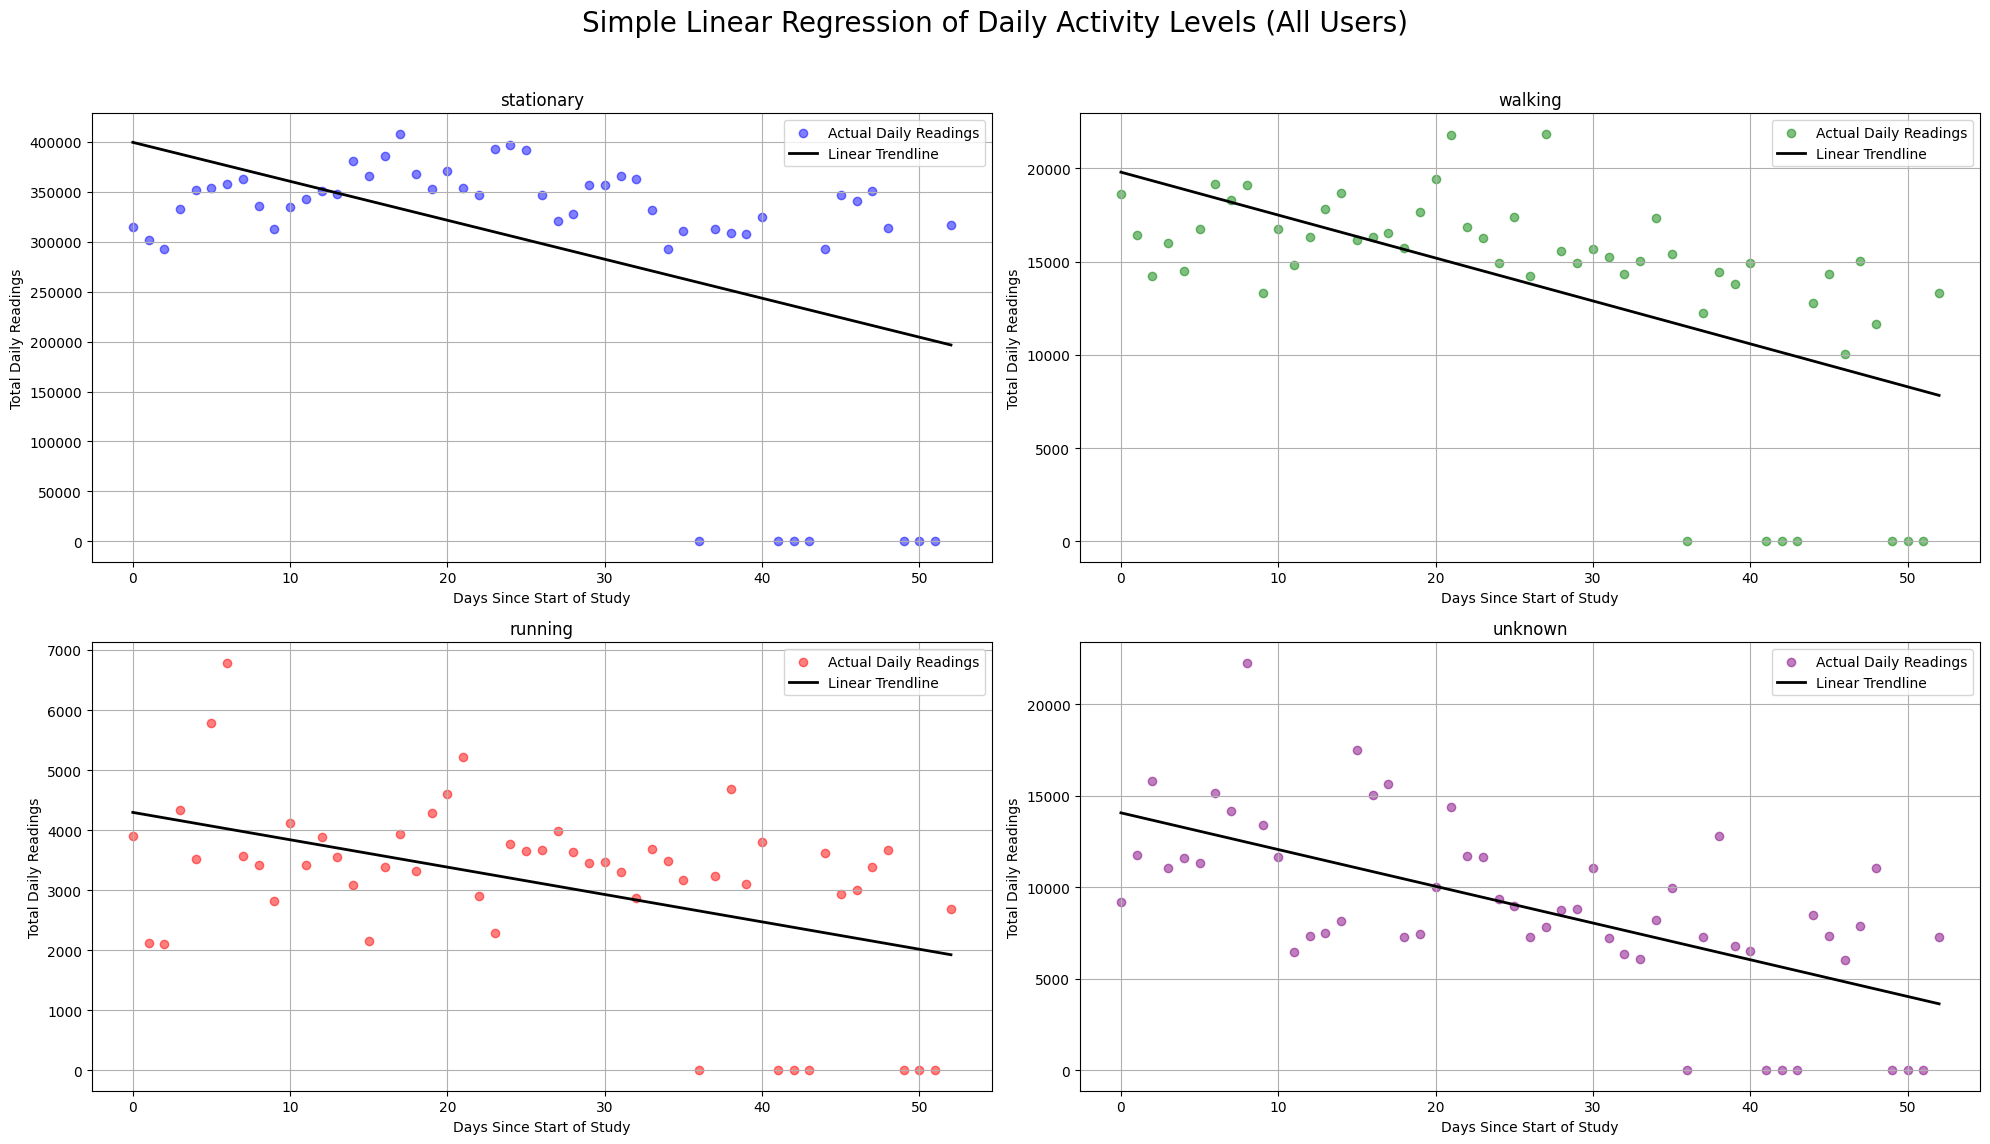

In [45]:
# Linear Regression model (with low complete days removed)

from sklearn.linear_model import LinearRegression

# Data prep

vectors_df = pd.get_dummies(final_cleaned_df['activity inference'], prefix='activity')
activity_df_wide = pd.concat([final_cleaned_df, vectors_df], axis=1)

daily_group_summary = activity_df_wide[['activity_0', 'activity_1', 'activity_2', 'activity_3']].resample('D').sum()

regression_df = daily_group_summary.reset_index()
regression_df['days_since_start'] = (regression_df['timestamp'] - regression_df['timestamp'].min()).dt.days


# 2x2 grid

activity_columns = ['activity_0', 'activity_1', 'activity_2', 'activity_3']
activity_titles = ['stationary', 'walking', 'running', 'unknown']
colors = ['blue', 'green', 'red', 'purple']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
fig.suptitle('Simple Linear Regression of Daily Activity Levels (All Users)', fontsize=20)

for i, activity in enumerate(activity_columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    X = regression_df[['days_since_start']]
    y = regression_df[activity]

    lr_model = LinearRegression()
    lr_model.fit(X, y)

    ax.scatter(X, y, color=colors[i], alpha=0.5, label='Actual Daily Readings')

    ax.plot(X, lr_model.predict(X), color='black', linewidth=2, label='Linear Trendline')

    ax.set_title(activity_titles[i])
    ax.set_ylabel('Total Daily Readings')
    ax.set_xlabel('Days Since Start of Study')
    ax.legend()
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [46]:
# Compare the Linear Progressive Model to the Polynomial Model (with low compliance days removed)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np

regression_df = daily_group_summary.reset_index()
regression_df['days_since_start'] = (regression_df['timestamp'] - regression_df['timestamp'].min()).dt.days

X = regression_df[['days_since_start']]
y = regression_df['activity_0'] # Focusing on Stationary activity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)


# Define error metrics

# Define the function for sMAPE
def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Calculate metrics for both models
metrics_data = {
    'Metric': ['RMSE', 'sMAPE (%)'],
    'Simple Linear Regression': [np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)), smape(y_test, y_pred_lr)],
    'Polynomial Regression (Deg 2)': [np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly)), smape(y_test, y_pred_poly)]
}

error_df = pd.DataFrame(metrics_data).set_index('Metric')

print("Model performance comparisons:")
error_df

Model performance comparisons:


,Simple Linear Regression,Polynomial Regression (Deg 2)
Metric,,
RMSE,139820.578235,128918.496808
sMAPE (%),63.869873,62.705884


In [48]:
# Cleaned Data Summary Stats (to find median)
daily_counts_cleaned = final_cleaned_df.groupby('user_id').resample('D').apply(
    'size'
)

print("NEW Summary Stats from final_cleaned_df")
print(daily_counts_cleaned.describe())

# Prep Median Imputation

# 25th percentile of the clean data is a good threshold
LOW_ACTIVITY_THRESHOLD = daily_counts_cleaned.quantile(0.25)
print(f"\nUsing a new low activity threshold of: {LOW_ACTIVITY_THRESHOLD:,.0f} readings per day.")

# Calculate the median of ONLY the good days from clean data
good_days_cleaned = daily_counts_cleaned[daily_counts_cleaned > LOW_ACTIVITY_THRESHOLD]
imputation_median = good_days_cleaned.median()
print(f"The new calculated median for imputation is: {imputation_median:,.0f} readings.")

imputed_series = daily_counts_cleaned.copy()
imputed_series[imputed_series <= LOW_ACTIVITY_THRESHOLD] = imputation_median

print("\nImputation done!")

NEW Summary Stats from final_cleaned_df
count     2498.000000
mean      6870.218175
std       4776.289906
min          0.000000
25%       6429.500000
50%       8101.500000
75%       8220.000000
max      41899.000000
dtype: float64

Using a new low activity threshold of: 6,430 readings per day.
The new calculated median for imputation is: 8,169 readings.

Imputation done!


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


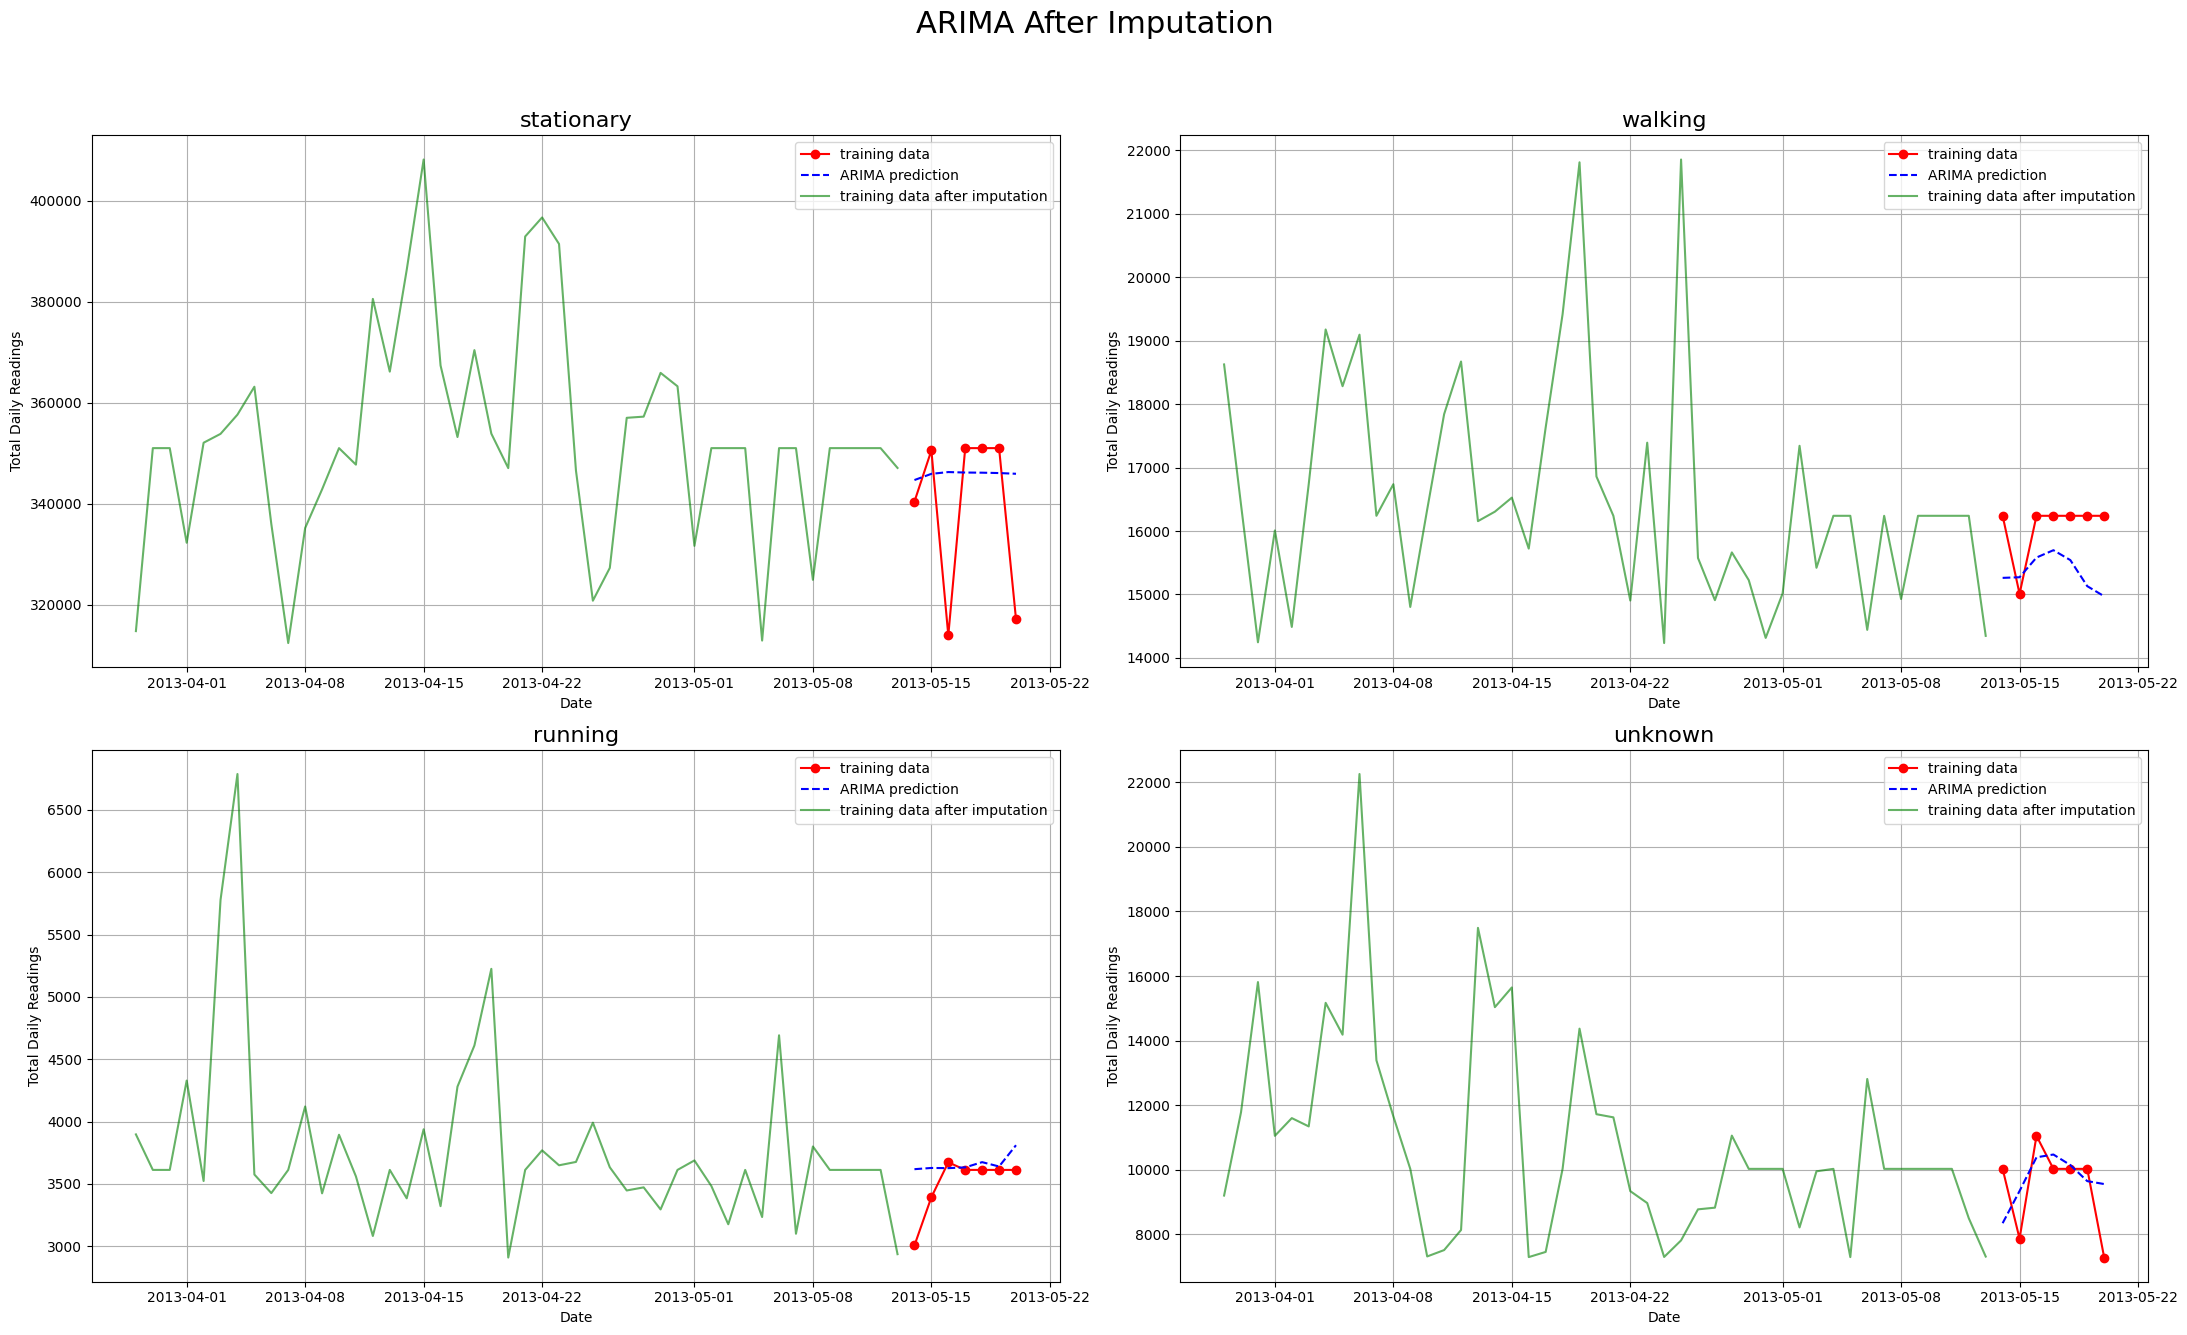

In [49]:
from statsmodels.tsa.arima.model import ARIMA

# Prep data for ARIMA


cleaned_vectors = pd.get_dummies(final_cleaned_df['activity inference'], prefix='activity')
final_cleaned_wide_df = pd.concat([final_cleaned_df, cleaned_vectors], axis=1)

daily_group_summary = final_cleaned_wide_df[['activity_0', 'activity_1', 'activity_2', 'activity_3']].resample('D').sum()

activity_columns = ['activity_0', 'activity_1', 'activity_2', 'activity_3']
activity_titles = ['stationary', 'walking', 'running', 'unknown']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 14))
fig.suptitle('ARIMA After Imputation', fontsize=22)

# For each activity_inference:
for i, activity in enumerate(activity_columns):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    model_series = daily_group_summary[activity]

    # MEDIAN VALUE IMPUTATION
    # Replace the noisy days using a threshold
    # Define a threshold for a low activity day using the 25th percentile of the whole cleaned data set
    LOW_ACTIVITY_THRESHOLD = model_series.quantile(0.25)

    # Calculate the median for ONLY the days with activity above the threshold
    active_days_median = model_series[model_series > LOW_ACTIVITY_THRESHOLD].median()

    # If there are no active days use the median
    if pd.isna(active_days_median):
        active_days_median = model_series.median()

    imputed_low_values_series = model_series.copy()

    # Replace the low values with the  median
    imputed_low_values_series[imputed_low_values_series <= LOW_ACTIVITY_THRESHOLD] = active_days_median

    # LINEAR INTERPOLATION FOR MISSING DAYS
    # Fill the calendar gaps created when unreliable days were removed
    full_date_range = pd.date_range(start=imputed_low_values_series.index.min(), end=imputed_low_values_series.index.max(), freq='D')
    final_imputed_series = imputed_low_values_series.reindex(full_date_range).interpolate(method='linear')

    # Fit the ARIMA Model
    train_data = final_imputed_series.iloc[:-7] # use all but the last 7 days for training
    test_data = final_imputed_series.iloc[-7:]  # the last 7 days are for testing


    arima_model = ARIMA(train_data, order=(7, 1, 1))
    model_fit = arima_model.fit()

    # Make predictions
    predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

    # plot
    ax.plot(test_data.index, test_data, label='training data', color='red', marker='o')
    ax.plot(predictions.index, predictions, label='ARIMA prediction', color='blue', linestyle='--')
    ax.plot(train_data.index, train_data, label='training data after imputation', color='green', alpha=0.6)

    # format
    ax.set_title(activity_titles[i], fontsize=16)
    ax.set_ylabel('Total Daily Readings')
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid(True)

# format plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Prep data for ARIMA


cleaned_vectors = pd.get_dummies(final_cleaned_df['activity inference'], prefix='activity')
final_cleaned_wide_df = pd.concat([final_cleaned_df, cleaned_vectors], axis=1)

daily_group_summary = final_cleaned_wide_df[['activity_0', 'activity_1', 'activity_2', 'activity_3']].resample('D').sum()

activity_columns = ['activity_0', 'activity_1', 'activity_2', 'activity_3']
activity_titles = ['stationary', 'walking', 'running', 'unknown']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 14))
fig.suptitle('ARIMA After Imputation', fontsize=22)

# For each activity_inference:
for i, activity in enumerate(activity_columns):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    model_series = daily_group_summary[activity]

    # MEDIAN VALUE IMPUTATION
    # Replace the noisy days using a threshold
    # Define a threshold for a low activity day using the 25th percentile of the whole cleaned data set
    LOW_ACTIVITY_THRESHOLD = model_series.quantile(0.25)

    # Calculate the median for ONLY the days with activity above the threshold
    active_days_median = model_series[model_series > LOW_ACTIVITY_THRESHOLD].median()

    # If there are no active days use the median
    if pd.isna(active_days_median):
        active_days_median = model_series.median()

    imputed_low_values_series = model_series.copy()

    # Replace the low values with the  median
    imputed_low_values_series[imputed_low_values_series <= LOW_ACTIVITY_THRESHOLD] = active_days_median

    # LINEAR INTERPOLATION FOR MISSING DAYS
    # Fill the calendar gaps created when unreliable days were removed
    full_date_range = pd.date_range(start=imputed_low_values_series.index.min(), end=imputed_low_values_series.index.max(), freq='D')
    final_imputed_series = imputed_low_values_series.reindex(full_date_range).interpolate(method='linear')

    # Fit the ARIMA Model
    train_data = final_imputed_series.iloc[:-7] # use all but the last 7 days for training
    test_data = final_imputed_series.iloc[-7:]  # the last 7 days are for testing

    # Summary observations for the model
    arima_model = ARIMA(train_data, order=(7, 1, 1))
    model_fit = arima_model.fit()
    print(model_fit.summary())

    # Make predictions
    predictions = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

    # plot
    # ax.plot(test_data.index, test_data, label='training data', color='red', marker='o')
    # ax.plot(predictions.index, predictions, label='ARIMA prediction', color='blue', linestyle='--')
    # ax.plot(train_data.index, train_data, label='training data after imputation', color='green', alpha=0.6)

    # Plot residuals
    residuals = model_fit.resid

    # residuals.plot(ax=ax, label = "Residuals")
    # ax.set_title(activity_titles[i])
    # ax.set_ylabel('Error Value')
    # ax.set_xlabel('Date')
    # ax.legend()
    # ax.grid(True)

    sns.kdeplot(residuals, ax=ax, fill=True, lw=3)

    # format
    # ax.set_title(activity_titles[i], fontsize=16)
    # ax.set_ylabel('Total Daily Readings')
    # ax.set_xlabel('Date')
    # ax.legend()
    # ax.grid(True)

# format plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NameError: name 'final_cleaned_df' is not defined

In [50]:
import pandas as pd

activity_counts = pd.crosstab(
    index=activity_df['user_id'],
    columns=activity_df['activity inference'],
    margins=True,
    margins_name="Total Readings"
)

activity_counts

activity inference,0,1,2,3,Total Readings
user_id,,,,,
u00,403461,30659,8990,18881,461991
u01,438583,20954,9778,5547,474862
u02,485697,29510,678,11633,527518
u03,404853,4623,423,1503,411402
u04,398779,33114,15733,14890,462516
u05,441160,16144,1400,12943,471647
u07,359551,14550,5226,8689,388016
u08,470389,24232,7794,6308,508723
u09,447910,25739,3910,11879,489438


In [51]:
import pandas as pd

activity_counts = pd.crosstab(
    index=final_cleaned_df['user_id'],
    columns=final_cleaned_df['activity inference'],
    margins=True,
    margins_name="Total Readings"
)

activity_counts

activity inference,0,1,2,3,Total Readings
user_id,,,,,
u00,305647,22476,7166,14072,349361
u01,314826,15550,7237,3758,341371
u02,340039,20074,402,7548,368063
u03,345204,4258,404,1430,351296
u04,317996,27981,13209,10704,369890
u05,339379,12554,1186,10794,363913
u07,318853,13685,4750,8465,345753
u08,341838,18254,5834,4334,370260
u09,316452,18925,2996,7647,346020


In [52]:
# Copy the imputated activity counts data to export to excel
csv_data = """user_id,0,1,2,3,Total Readings
u00,305647,22476,7166,14072,349361
u01,314826,15550,7237,3758,341371
u02,340039,20074,402,7548,368063
u03,345204,4258,404,1430,351296
u04,317996,27981,13209,10704,369890
u05,339379,12554,1186,10794,363913
u07,318853,13685,4750,8465,345753
u08,341838,18254,5834,4334,370260
u09,316452,18925,2996,7647,346020
u10,358093,11311,2758,3259,375421
u12,344268,9423,3908,10426,368025
u13,315670,7832,2710,9250,335462
u14,320254,33297,2931,5476,361958
u15,204742,7208,637,8449,221036
u16,331930,14762,1926,4335,352953
u17,357880,11790,1497,4698,375865
u18,313082,10564,1231,6109,330986
u19,343449,13801,202,6184,363636
u20,295918,6935,356,2184,305393
u22,287839,10170,4717,5209,307935
u23,366481,7124,871,4202,378678
u24,223997,10109,2785,2686,239577
u25,192182,11923,3275,11894,219274
u27,342125,9866,1192,7138,360321
u30,325260,21822,2500,19301,368883
u31,336883,13894,1843,14012,366632
u32,296509,17219,1694,10864,326286
u33,342244,15573,1733,6097,365647
u34,254984,10539,1783,23226,290532
u35,355816,9884,4793,6339,376832
u36,336420,14291,7947,12681,371339
u39,161628,493,26,652,162799
u41,274418,7545,1288,1801,285052
u42,300030,7744,1059,10724,319557
u43,285825,16331,3283,9441,314880
u44,325379,6100,559,3345,335383
u45,278425,7388,868,23267,309948
u46,300601,28253,10632,10903,350389
u47,268884,5457,362,6750,281453
u49,356997,16413,2175,6991,382576
u50,259326,4274,84,6477,270161
u51,346335,17713,6607,6397,377052
u52,143097,15959,3632,9995,172683
u53,339115,8121,623,6872,354731
u54,271649,16250,2291,8668,298858
u56,312454,13193,3043,11758,340448
u57,314958,18817,9798,11738,355311
u58,343789,12399,1663,7650,365501
u59,1127021,96362,20380,72662,1316425
Total Readings,15796191,731906,164846,468862,17161805
"""

In [3]:
import pandas as pd

# Replace 'your_file_name.xlsx' with the actual name of your Excel file.
# Make sure the file is uploaded to your Google Colab environment.
file_path = '/content/gdrive/MyDrive/studentlifevariables.xlsx'

# Load the data from the Excel file into a new, complete DataFrame
# If your data is on a specific sheet, you can specify it like this:
# df_full = pd.read_excel(file_path, sheet_name='Sheet1')
df_full = pd.read_excel(file_path)

# Display the column names, non-null counts, and data types
print("--- DataFrame Info ---")
df_full.info()

# Display the first 5 rows to visually check the columns
print("\n--- First 5 Rows ---")
print(df_full.head())

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 52 columns):
 #   Column                                                                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                                                                 --------------  -----  
 0   uid                                                                                                                                                    49 non-null     object 
 1   days online                                                                                                                                            49 non-null     int64  
 2   views                                                                                                                                                

--- Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 19 columns):
 #   Column                                                                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                                                                 --------------  -----  
 0   uid                                                                                                                                                    49 non-null     object 
 1   days online                                                                                                                                            49 non-null     int64  
 2   views                                                                                                                                        


--- DataFrame with 'uid' as Index ---
     days online  views  contributions  questions  notes  answers  gpa all  \
uid                                                                          
u00           49    162            144          0     67       22      NaN   
u01           29    299              5          1      1        0     2.86   
u02           57    299              0          0      0        0     3.51   
u03           47    262             30         15      2        6      NaN   
u04           27    101              1          1      0        0     3.03   

      gpa 13s  cs 65  activity_0 (stationary)  activity_1 (walking)  \
uid                                                                   
u00       NaN    NaN                   305647                 22476   
u01  1.777778    3.0                   314826                 15550   
u02  4.000000    4.0                   340039                 20074   
u03       NaN    NaN                   345204              

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''